Dataset Description:-

See, fork, and run a random forest benchmark model through Kaggle Scripts
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.


Data Fields:-
    
-- datetime - hourly date + timestamp  
--season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
--holiday - whether the day is considered a holiday
--workingday - whether the day is neither a weekend nor holiday
--weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
--temp - temperature in Celsius
--atemp - "feels like" temperature in Celsius
--humidity - relative humidity
--windspeed - wind speed
--casual - number of non-registered user rentals initiated
--registered - number of registered user rentals initiated
--count - number of total rentals


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
bike_data = pd.read_csv("train.csv")
bike_test_data = pd.read_csv("test.csv")

## Quick Data Insights

In [3]:
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1/1/2011 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1/1/2011 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1/1/2011 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1/1/2011 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1/1/2011 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
bike_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
for column in bike_data:
    if column not in ["count","casual","registered"]:
        unique_values = bike_data[column].unique()
        print(column,":-",unique_values)
        print("     ")
        print("--------------------------")

datetime :- ['1/1/2011 0:00' '1/1/2011 1:00' '1/1/2011 2:00' ... '12/19/2012 21:00'
 '12/19/2012 22:00' '12/19/2012 23:00']
     
--------------------------
season :- [1 2 3 4]
     
--------------------------
holiday :- [0 1]
     
--------------------------
workingday :- [0 1]
     
--------------------------
weather :- [1 2 3 4]
     
--------------------------
temp :- [ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3
 10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46 21.32 22.96 23.78
 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7  30.34 31.16 29.52
 33.62 35.26 36.9  32.8  31.98 34.44 36.08 37.72 38.54  1.64  0.82 39.36
 41.  ]
     
--------------------------
atemp :- [14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455
 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575
 15.91   3.03   3.79   4.545 15.15  18.18  25.    26.515 27.275 29.545
 23.485 25.76  31.06  30.305 24.24  18.94  31.82  32.575 33.335 28.79
 

In [7]:
for column in bike_data:
    if column not in ["count","casual","registered","temp","atemp"]:
        value_counts = bike_data[column].value_counts()
        print(column,":")
        print(value_counts)
        print("     ")
        print("--------------------------")

datetime :
1/1/2011 0:00       1
5/1/2012 21:00      1
5/1/2012 13:00      1
5/1/2012 14:00      1
5/1/2012 15:00      1
                   ..
9/2/2011 4:00       1
9/2/2011 5:00       1
9/2/2011 6:00       1
9/2/2011 7:00       1
12/19/2012 23:00    1
Name: datetime, Length: 10886, dtype: int64
     
--------------------------
season :
4    2734
2    2733
3    2733
1    2686
Name: season, dtype: int64
     
--------------------------
holiday :
0    10575
1      311
Name: holiday, dtype: int64
     
--------------------------
workingday :
1    7412
0    3474
Name: workingday, dtype: int64
     
--------------------------
weather :
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
     
--------------------------
humidity :
88    368
94    324
83    316
87    289
70    259
     ... 
8       1
10      1
97      1
96      1
91      1
Name: humidity, Length: 89, dtype: int64
     
--------------------------
windspeed :
0.0000     1313
8.9981     1120
11.0014    1057
12.99

## Data Preprcessing

In [8]:
bike_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [9]:
bike_data["datetime"]

0           1/1/2011 0:00
1           1/1/2011 1:00
2           1/1/2011 2:00
3           1/1/2011 3:00
4           1/1/2011 4:00
               ...       
10881    12/19/2012 19:00
10882    12/19/2012 20:00
10883    12/19/2012 21:00
10884    12/19/2012 22:00
10885    12/19/2012 23:00
Name: datetime, Length: 10886, dtype: object

In [10]:
# For time being, ignoring datetime
bike_data.drop("datetime", axis=1, inplace = True)

In [11]:
bike_data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## Data Visualization

In [12]:
category = bike_data.drop(["temp", "atemp", "humidity", "windspeed", "casual", "registered", "count"], axis=1)
continuous = bike_data.drop(["season", "holiday", "workingday", "weather"], axis=1)
category.head()

,season,holiday,workingday,weather
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1


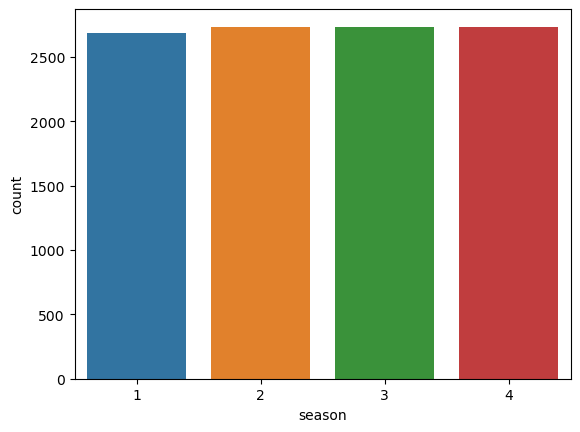

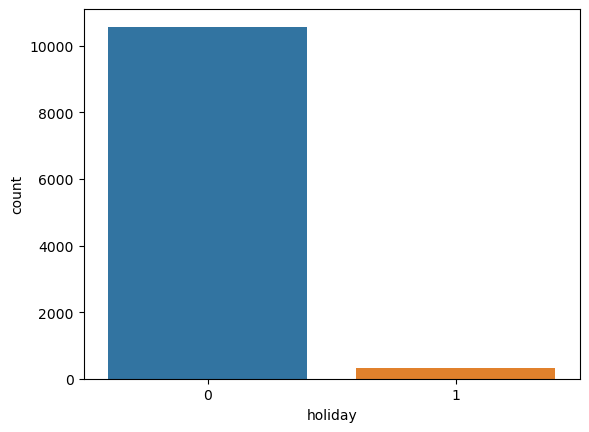

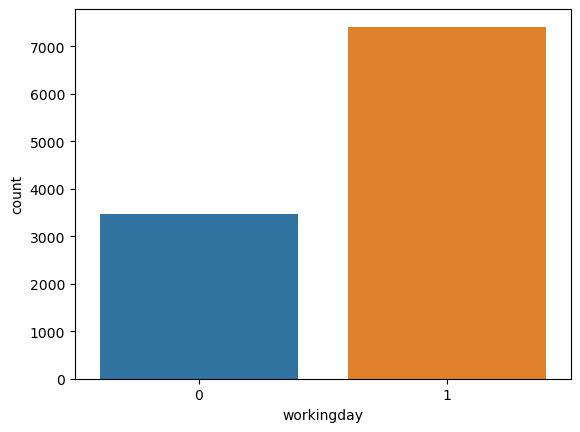

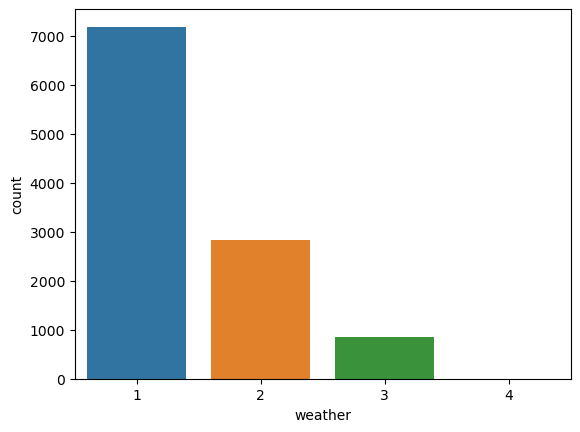

In [13]:
for column in category:
    sns.countplot(data = category, x=column)
    plt.show()

## subplot

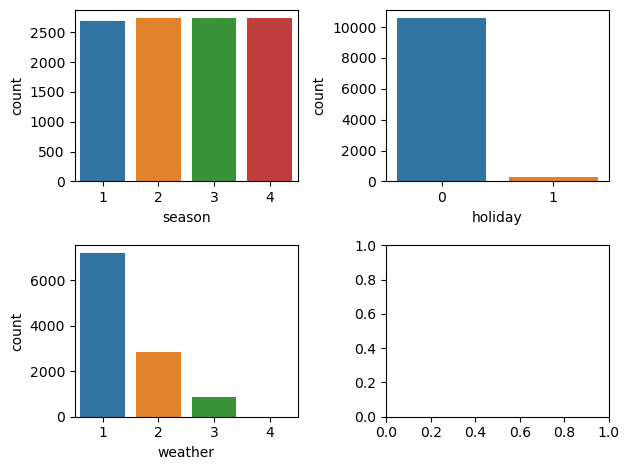

In [14]:
%matplotlib inline
sns.countplot(data = category, x="workingday")
plt.subplot(2, 2, 1)

sns.countplot(data = category, x="season")
plt.subplot(2, 2, 2)

sns.countplot(data = category, x="holiday")
plt.subplot(2, 2, 3)

sns.countplot(data = category, x="weather")
plt.subplot(2, 2, 4)

plt.tight_layout()


C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


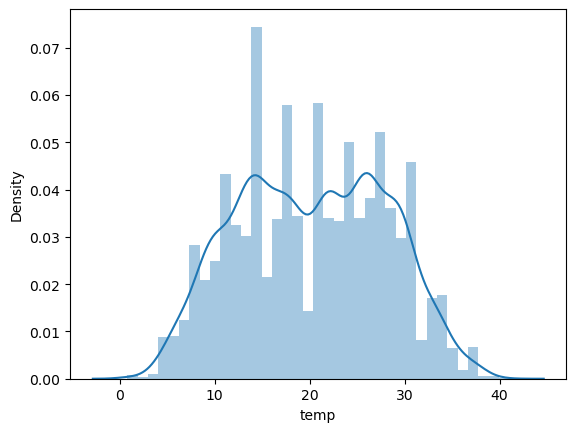

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


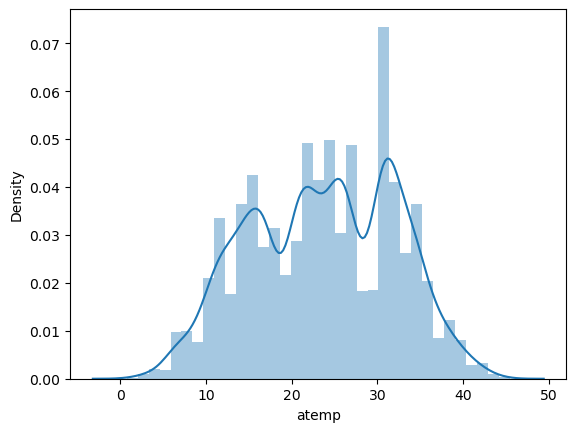

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


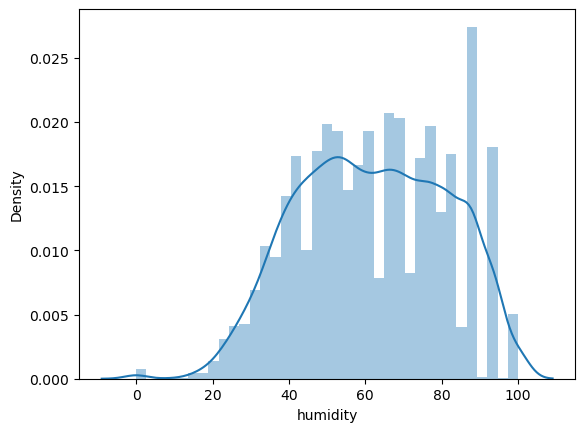

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


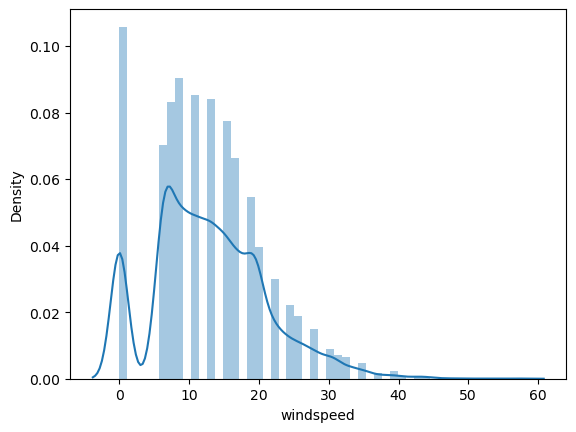

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


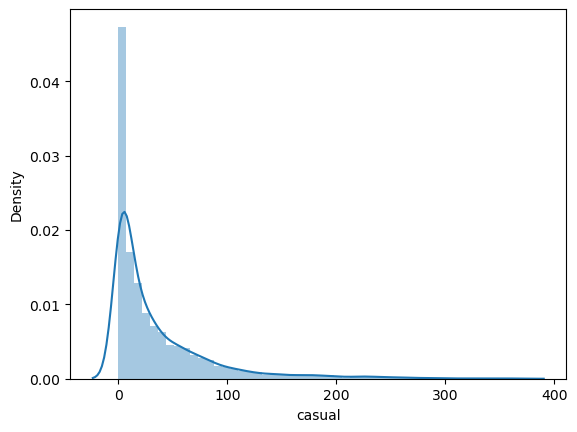

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


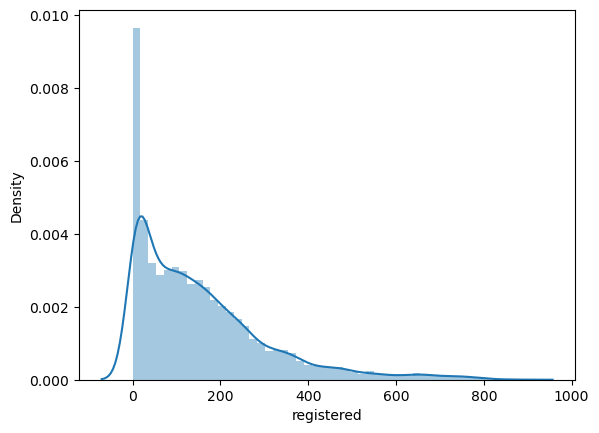

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


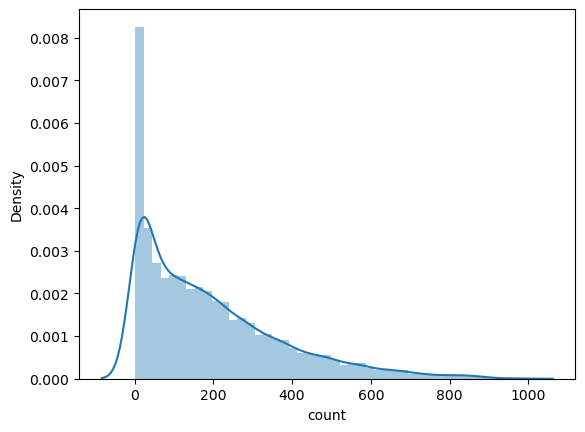

In [15]:
for column in continuous:
    sns.distplot(continuous[column])
    plt.show()

## Implementing Algorithm without any Preprocessing

In [16]:
x = bike_data.drop(["count"], axis=1)
y = bike_data["count"]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=50)

In [23]:
lin_algo = LinearRegression()

In [24]:
lin_algo.fit(x_train, y_train)

LinearRegression()

In [25]:
prediction = lin_algo.predict(x_test)

In [26]:
r2_score(y_test, prediction)

1.0

In [35]:
x_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
7096,2,0,0,1,16.40,20.455,58,8.9981,10,60
10641,4,0,0,3,15.58,19.695,94,6.0032,12,110
1696,2,0,0,3,21.32,25.000,83,39.0007,14,49
8784,3,0,1,2,31.16,36.365,66,0.0000,33,308
8747,3,0,1,1,31.16,36.365,66,11.0014,89,368


In [33]:
prediction = lin_algo.predict([[4,0,0,3,15.58,19,94,6.003,12,110]])
prediction

C:\Users\admin\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([122.])

In [34]:
y_test.head()

7096      70
10641    122
1696      63
8784     341
8747     457
Name: count, dtype: int64